# COVID-19: Chest X-ray Medical Diagnosis

## Imports

In [ ]:
import os

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

!pip install torchsummary
from tqdm import tqdm
from torchsummary import summary as summary # if not installed, install by executing (!pip install torchsummary)

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


## Model building

In [ ]:
model = models.resnet50(pretrained = True)

for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 2))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Device setting

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Model init.

In [ ]:
model.to(device)
print(model(torch.rand((1, 3, 224, 224), device=device)).shape)

summary(model, (3, 224, 224))

torch.Size([1, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14

## Hyperparams

In [ ]:
epochs = 7
batch_size = 64
lr = 0.01
load_model = True

## Data prep.

In [ ]:
data_dir = r'/COVID'

In [ ]:
def get_loader(data_dir, batch_size = 64):
    print("\nData Gathering...")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])
                                  
    data = datasets.ImageFolder(root = data_dir, transform = transform)

    train_set, val_set = random_split(data, [1800, 479], 
                                      generator = torch.Generator().manual_seed(101))
    val_set, test_set = random_split(val_set, [240, 239],
                                     generator = torch.Generator().manual_seed(101))

    
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

    print("Loader Prep. successful!...")
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_loader(data_dir, batch_size)


Data Gathering...
Loader Prep. successful!...


## Visualization

In [ ]:
nor = []
pne = []
for i, dir in enumerate(os.listdir(data_dir)):
  path = os.path.join(data_dir, dir)
  for idx, img in enumerate(os.listdir(path)):
    img_path = os.path.join(path, img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (1000, 1000))
    img = np.asarray(img)

    if idx > 3:
      break

    if i == 0:
      pne.append(img)
    else:
      nor.append(img)

### Normal samples

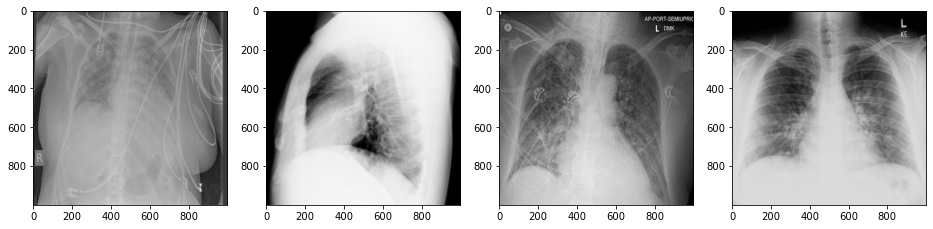

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 16))
for idx, img in enumerate(nor):
  ax[idx].imshow(img)
fig.show()

### Pneumonia samples

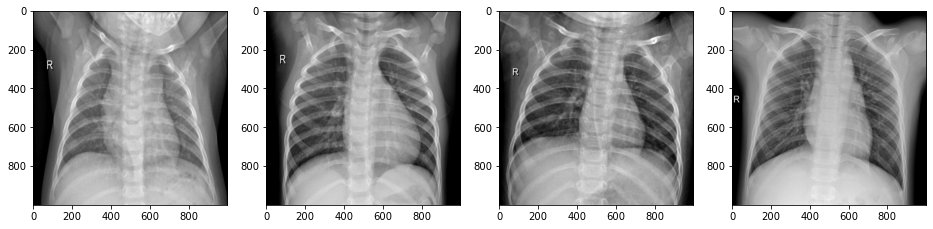

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 16))
for idx, img in enumerate(pne):
  ax[idx].imshow(img)
fig.show()

## Utility funcs.

In [ ]:
# Saving checkpoints
def save_checkpoint(state, filename = 'covid_pneumonia_model.pth.tar'):
  print("--> Saving checkpoint...\n")
  torch.save(state, filename)

# Loading checkpoints
def load_checkpoint(checkpoint):
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])

# Calculating model metrics
def check_acc(model, loader, need_loss = False):
      num_samples = 0
      num_correct = 0
      loss_each_batch = []
      model.eval()
      with torch.no_grad():
          for X, y in loader:
              X, y = X.to(device), y.to(device)
              output = model(X)
              if need_loss:
                  loss = criterion(output, y)
                  loss_each_batch.append(loss.item())
              _, prediction = output.max(dim = 1)
              num_correct += (prediction == y).sum()
              num_samples += prediction.size(0)
              
          
      model.train()
      if need_loss:
          return (num_correct / num_samples) * 100.0, np.mean(loss_each_batch)
      else:
          return (num_correct / num_samples) * 100.0

## Loss and optim. 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 0.0001)

## Model training
### *Note: Can load the trained model by executing next cell.<br>-->Don't run training cell if you gonna use trained model which is loaded.<br>-->For fresh training, set load_model = False in hyperparams cell and run training cell<br>-->To further train the saved model, set load_model = True and run both the cells*

In [ ]:
if load_model:
    load_checkpoint(torch.load(r'/covid_pneumonia_model.pth.tar'))

In [ ]:
print("\nTraining starts...")

epoch_arr = []
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(epochs):

    if epoch % 2 == 0 and epoch != 0:
        checkpoint = {
            'epoch' : epoch,
            'state_dict' : model.state_dict(), 
            'optimizer': optimizer.state_dict(),
            }
        save_checkpoint(checkpoint, 
                        filename = r'/covid_pneumonia_model.pth.tar')

    for X, y in tqdm(train_loader):
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    e_train_acc = check_acc(model, train_loader)
    e_val_acc, e_val_loss = check_acc(model, val_loader, need_loss = True)
    e_train_loss = loss.item()

    epoch_arr.append(epoch + 1)
    train_acc.append(e_train_acc.item())
    train_loss.append(e_train_loss)
    val_acc.append(e_val_acc.item())
    val_loss.append(e_val_loss)

    print(f'Epoch: {epoch + 1} | Train Accuracy: {e_train_acc} | Val. Accuracy: {e_val_acc} | Train Loss: {e_train_loss} | Val. Loss: {e_val_loss}\n')

    data = {
        'epochs' : epoch_arr,
        'train_acc' : train_acc,
        'val_acc' : val_acc,
        'train_loss' : train_loss,
        'val_loss' : val_loss
    }
    model_metrics = pd.DataFrame(data = data)
    model_metrics.to_csv(r'/model_metrics.csv')


    if epoch == epochs - 1:
      print("\nFinal checkpoint")
      checkpoint = {
          'epoch' : epoch,
          'state_dict' : model.state_dict(), 
          'optimizer': optimizer.state_dict(),
          }
      save_checkpoint(checkpoint, 
                      filename = r'/covid_pneumonia_model.pth.tar')


Training starts...


100%|██████████| 29/29 [08:56<00:00, 18.50s/it]


Epoch: 1 | Train Accuracy: 97.77777862548828 | Val. Accuracy: 96.66666412353516 | Train Loss: 0.0024241148494184017 | Val. Loss: 0.10653252713382244



100%|██████████| 29/29 [08:47<00:00, 18.18s/it]


Epoch: 2 | Train Accuracy: 96.66666412353516 | Val. Accuracy: 95.41666412353516 | Train Loss: 2.5771048069000244 | Val. Loss: 0.14452244946733117

--> Saving checkpoint...



100%|██████████| 29/29 [08:45<00:00, 18.11s/it]


Epoch: 3 | Train Accuracy: 99.16666412353516 | Val. Accuracy: 99.16666412353516 | Train Loss: 0.004186064470559359 | Val. Loss: 0.027393980068154633



100%|██████████| 29/29 [08:45<00:00, 18.12s/it]


Epoch: 4 | Train Accuracy: 99.27777862548828 | Val. Accuracy: 98.75 | Train Loss: 0.20500075817108154 | Val. Loss: 0.03236605674828752

--> Saving checkpoint...



100%|██████████| 29/29 [08:54<00:00, 18.42s/it]


Epoch: 5 | Train Accuracy: 99.3888931274414 | Val. Accuracy: 99.16666412353516 | Train Loss: 0.4614166021347046 | Val. Loss: 0.02768086069772835



100%|██████████| 29/29 [08:50<00:00, 18.31s/it]


Epoch: 6 | Train Accuracy: 99.22222137451172 | Val. Accuracy: 98.75 | Train Loss: 0.000616047705989331 | Val. Loss: 0.030838907696306705

--> Saving checkpoint...



100%|██████████| 29/29 [08:45<00:00, 18.11s/it]


Epoch: 7 | Train Accuracy: 99.44444274902344 | Val. Accuracy: 99.16666412353516 | Train Loss: 0.007271359674632549 | Val. Loss: 0.027156554482644424


Final checkpoint
--> Saving checkpoint...



## Sample prediction

In [ ]:
def data_prep_for_pred(img_dir):
  img = cv2.imread(img_dir)
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Resize((224, 224))
  ])
  img = transform(img)
  plt.imshow(img.permute(1, 2, 0))
  plt.show()
  img = img.unsqueeze(0)
  return img

def predict(model, img_dir):
  model.eval()

  img = data_prep_for_pred(img_dir)
  img = img.to(device)

  output = model(img)
  _, pred = output.max(dim = 1)

  classes = ['Normal', 'Pneumonia']
  print(f'Predicted class: {classes[pred]}')

  model.train()

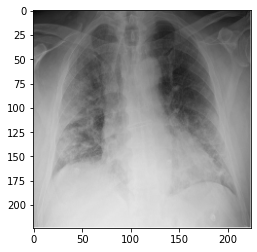

Predicted class: Pneumonia


In [ ]:
predict(model, r'/samples/p1.jpg')

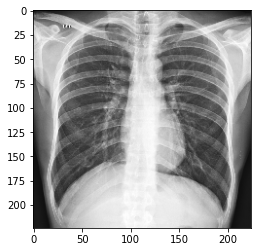

Predicted class: Normal


In [ ]:
predict(model, r'/samples/n3.jpeg')

## Model evaluation

### Loss and Accuracy

In [ ]:
test_acc, test_loss = check_acc(model, test_loader, need_loss = True)
print(f'Test Metrics:\nLoss: {test_loss}\nAccuracy: {test_acc} %')
model.eval()
y_pred = torch.empty(0)
y_act = torch.empty(0)
for idx, (X, y) in enumerate(test_loader):
  X, y = X.to(device), y.to(device)
  output = model(X)

  _, prediction = output.max(dim = 1)
  y_pred = torch.cat([y_pred, prediction.view(-1).cpu()])
  y_act = torch.cat([y_act, y.view(-1).cpu()])

model.train()

y_pred = y_pred.numpy()
y_act = y_act.numpy()

Test Metrics:
Loss: 0.014969506606576033
Accuracy: 99.58158874511719 %


### Confusion matrix

In [ ]:
cm = confusion_matrix(y_pred, y_act)
print(cm)

[[147   0]
 [  1  91]]


### Classification report

In [ ]:
cr = classification_report(y_pred, y_act)
print(cr)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       147
         1.0       1.00      0.99      0.99        92

    accuracy                           1.00       239
   macro avg       1.00      0.99      1.00       239
weighted avg       1.00      1.00      1.00       239



# Thank you!